In [1]:
import os
import librosa
import torch
import torchaudio
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

# Path to your dataset
DATA_PATH = "/kaggle/input/google-speech-commands/"

# Hyperparameters
SAMPLE_RATE = 16000
DURATION = 1.0  
N_MELS = 128
N_FFT = 400
HOP_LENGTH = N_FFT // 2

def load_audio(file_path, target_sr=SAMPLE_RATE, duration=DURATION):
    """Load and preprocess audio file"""
    audio, sr = librosa.load(file_path, sr=target_sr, duration=duration)
    audio = librosa.util.fix_length(audio, size=int(target_sr * duration))  # Pad/Trim
    return audio

def extract_features(file_path):
    """Extract mel spectrogram features"""
    audio = load_audio(file_path)
    mel_spec = librosa.feature.melspectrogram(y=audio, sr=SAMPLE_RATE, n_mels=N_MELS, n_fft=N_FFT)
    mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
    return mel_spec_db

def create_dataset(data_path):
    """Load and extract features from the dataset"""
    X, y = [], []
    all_items = sorted(os.listdir(data_path))
    classes = [item for item in all_items 
               if os.path.isdir(os.path.join(data_path, item)) 
               and item != "_background_noise_"]

    label_map = {label: idx for idx, label in enumerate(classes)}

    for label in classes:
        folder = os.path.join(data_path, label)
        for file_name in os.listdir(folder):
            file_path = os.path.join(folder, file_name)

           
            if file_path.endswith(('.wav', '.mp3', '.flac')):  
                features = extract_features(file_path)
                X.append(features)
                y.append(label_map[label])

    return np.array(X), np.array(y), label_map

# Load dataset
X, y, label_map = create_dataset(DATA_PATH)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [3]:
class AudioDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32).unsqueeze(1)  
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create PyTorch Datasets
train_dataset = AudioDataset(X_train, y_train)
test_dataset = AudioDataset(X_test, y_test)

# DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)


In [4]:
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
import torch
from IPython.display import Audio

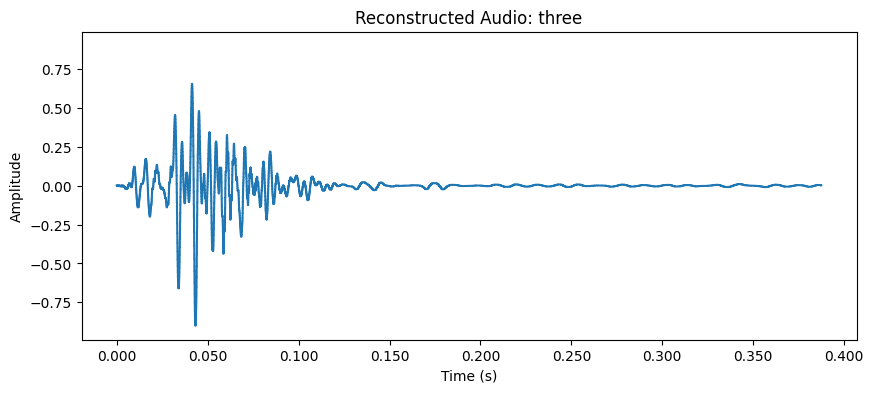

In [5]:
label_map = {0: 'bed', 1: 'bird', 2: 'cat', 3: 'dog', 4: 'down', 5: 'eight',
             6: 'five', 7: 'four', 8: 'go', 9: 'happy', 10: 'house', 11: 'left',
             12: 'marvin', 13: 'nine', 14: 'no', 15: 'off', 16: 'on', 17: 'one',
             18: 'right', 19: 'seven', 20: 'sheila', 21: 'six', 22: 'stop',
             23: 'three', 24: 'tree', 25: 'two', 26: 'up', 27: 'wow', 28: 'yes', 29: 'zero'}
HOP_LENGTH = N_FFT // 2 

for batch in train_loader:
    audio, labels = batch
    
    
    mel_spectrogram = audio[0].numpy()  
    label_idx = labels[0].item()  
    class_name = label_map[label_idx]  # Map to class name

    # Convert from dB to power spectrogram
    mel_power = librosa.db_to_power(mel_spectrogram)

    
    mel_to_linear = librosa.feature.inverse.mel_to_stft(
        mel_power, sr=SAMPLE_RATE, n_fft=N_FFT, power=1.0
    )

    # Use Griffin-Lim to reconstruct waveform
    waveform = librosa.griffinlim(mel_to_linear, hop_length=HOP_LENGTH, win_length=N_FFT)

    # Plot the waveform
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(waveform, sr=SAMPLE_RATE)
    plt.title(f"Reconstructed Audio: {class_name}")
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.show()

    # Play the reconstructed audio
    display(Audio(waveform, rate=SAMPLE_RATE))

    break  

In [ ]:
class xLSTMCell(nn.Module):
    """xLSTM Cell with Exponential Gating"""
    def __init__(self, input_dim, hidden_dim):
        super(xLSTMCell, self).__init__()
        
        
        self.w_ih = nn.Linear(input_dim, 4 * hidden_dim)  
        self.w_hh = nn.Linear(hidden_dim, 4 * hidden_dim)  

    def forward(self, x, hidden):
        h_prev, c_prev = hidden

        # Compute gates
        gates = self.w_ih(x) + self.w_hh(h_prev)
        i, f, o, g = torch.chunk(gates, 4, dim=1)

        # Exponential gating
        input_gate = torch.sigmoid(i)
        forget_gate = torch.sigmoid(f)
        output_gate = torch.sigmoid(o)

        # Update cell and hidden states
        cell_state = (forget_gate * c_prev) + (input_gate * torch.tanh(g))
        hidden_state = output_gate * torch.tanh(cell_state)

        return hidden_state, (hidden_state, cell_state)


In [ ]:
print(X.shape[2])

In [ ]:
for batch in train_loader:
    audios, labels = batch
    print(audios[0].shape)
    print(audios[0])
    print(len(audios))
    break

In [ ]:
class xLSTMModel(nn.Module):
    """Multi-layer xLSTM model"""
    def __init__(self, input_dim, hidden_dim, num_classes, num_layers=3):
        super(xLSTMModel, self).__init__()
        
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        # xLSTM layers
        self.xlstm_cells = nn.ModuleList(
            [xLSTMCell(input_dim, hidden_dim)] + 
            [xLSTMCell(hidden_dim, hidden_dim) for _ in range(num_layers - 1)]
        )

        # Classification head
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        """
        x shape: (batch_size, 1, 128, time_steps)
        """
        batch_size, _, mel_bins, time_steps = x.shape

        
        x = x.view(batch_size, time_steps, mel_bins)

        # Initialize hidden and cell states
        h = [torch.zeros(batch_size, self.hidden_dim).to(x.device) for _ in range(self.num_layers)]
        c = [torch.zeros(batch_size, self.hidden_dim).to(x.device) for _ in range(self.num_layers)]
        
        # Process over time steps
        for t in range(time_steps):
            x_t = x[:, t, :]  
            
            for layer in range(self.num_layers):
                h[layer], (h[layer], c[layer]) = self.xlstm_cells[layer](x_t, (h[layer], c[layer]))

       
        x = h[-1] 
        x = self.fc(x)
        
        return x
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Model parameters
num_classes = len(label_map) 
input_dim = 128  # Mel spectrogram bins 
hidden_dim = 128
num_layers = 3

# Initialize the model
model = xLSTMModel(input_dim, hidden_dim, num_classes, num_layers).to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [ ]:
class xLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(xLSTMCell, self).__init__()
        self.hidden_dim = hidden_dim
        
        # xLSTM cell weights
        self.Wx = nn.Linear(input_dim, 4 * hidden_dim) 
        self.Wh = nn.Linear(hidden_dim, 4 * hidden_dim)  
        
        # For gating
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()
        
    def forward(self, x, h_prev, c_prev):
        # Linear transformation of the input and previous hidden state
        gates = self.Wx(x) + self.Wh(h_prev)
        
        # Split into input, forget, output, and cell gates
        i_gate, f_gate, o_gate, g_gate = gates.chunk(4, dim=-1)
        
        # Apply sigmoid and tanh to gates
        i_gate = self.sigmoid(i_gate)
        f_gate = self.sigmoid(f_gate)
        o_gate = self.sigmoid(o_gate)
        g_gate = self.tanh(g_gate)
        
        # Cell state
        c_next = f_gate * c_prev + i_gate * g_gate
        
        # Hidden state
        h_next = o_gate * self.tanh(c_next)
        
        return h_next, c_next

class xLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(xLSTM, self).__init__()
        
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim
        
        # Creating xLSTM cells for multiple layers
        self.cells = nn.ModuleList([xLSTMCell(input_dim if i == 0 else hidden_dim, hidden_dim) for i in range(num_layers)])
        
        # Dropout layer
        self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        batch_size, seq_len, mel_bins = x.size()
        
        # Initialize hidden and cell states
        h = [torch.zeros(batch_size, self.hidden_dim).to(x.device) for _ in range(self.num_layers)]
        c = [torch.zeros(batch_size, self.hidden_dim).to(x.device) for _ in range(self.num_layers)]
        
        # Loop through the sequence
        for t in range(seq_len):
            x_t = x[:, t, :]  # Select t-th time step
            for layer in range(self.num_layers):
                h[layer], c[layer] = self.cells[layer](x_t, h[layer], c[layer])
                x_t = self.dropout(h[layer])  
        
        return h[-1]  # Return the hidden state from the last layer

class xLSTMClassifier(nn.Module):
    def __init__(self, mel_bins, time_steps, hidden_dim, num_layers, num_classes):
        super(xLSTMClassifier, self).__init__()
        
        # Reshape input to fit LSTM cell structure
        self.xlstm = xLSTM(mel_bins, hidden_dim, num_layers)
        
        # Fully connected layer for final prediction
        self.fc = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x):
        # Reshape input to (batch_size, time_steps, mel_bins)
        x = x.squeeze(1).permute(0, 2, 1)  # Shape: [batch_size, time_steps, mel_bins]
        
        # Pass through xLSTM
        x = self.xlstm(x)
        
        # Pass through fully connected layer
        out = self.fc(x)
        
        return out


input_dim = 128  # mel_bins
time_steps = 32  # time_steps
hidden_dim = 128
num_layers = 2
num_classes = len(label_map)  
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = xLSTMClassifier(mel_bins=input_dim, time_steps=time_steps, hidden_dim=hidden_dim, num_layers=num_layers, num_classes=num_classes).to(device)
print(model)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class xLSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(xLSTMCell, self).__init__()
        self.hidden_dim = hidden_dim

        # Weight matrices
        self.Wx = nn.Linear(input_dim, 4 * hidden_dim)  
        self.Wh = nn.Linear(hidden_dim, 4 * hidden_dim)  
        self.Wm = nn.Linear(hidden_dim, hidden_dim)  

        # Exponential gating parameters
        self.Wg = nn.Linear(hidden_dim, hidden_dim)
        self.sigmoid = nn.Sigmoid()
        self.tanh = nn.Tanh()

    def forward(self, x, h_prev, c_prev, m_prev):
        # Compute gates
        gates = self.Wx(x) + self.Wh(h_prev)
        i_gate, f_gate, o_gate, g_gate = gates.chunk(4, dim=-1)

       
        i_gate = self.sigmoid(i_gate)
        f_gate = self.sigmoid(f_gate)
        o_gate = self.sigmoid(o_gate)
        g_gate = self.tanh(g_gate)

        # Matrix Memory transformation
        m_next = self.tanh(self.Wm(m_prev))

        # Exponential Gating mechanism
        exp_gate = self.sigmoid(self.Wg(m_prev))
        c_next = (f_gate * c_prev) + (i_gate * g_gate) + (exp_gate * m_next)
        h_next = o_gate * self.tanh(c_next)

        return h_next, c_next, m_next

class xLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers):
        super(xLSTM, self).__init__()
        self.num_layers = num_layers
        self.hidden_dim = hidden_dim

        # Stack multiple xLSTM cells
        self.cells = nn.ModuleList([
            xLSTMCell(input_dim if i == 0 else hidden_dim, hidden_dim) for i in range(num_layers)
        ])
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        batch_size, seq_len, _ = x.size()
        h = [torch.zeros(batch_size, self.hidden_dim).to(x.device) for _ in range(self.num_layers)]
        c = [torch.zeros(batch_size, self.hidden_dim).to(x.device) for _ in range(self.num_layers)]
        m = [torch.zeros(batch_size, self.hidden_dim).to(x.device) for _ in range(self.num_layers)]

        for t in range(seq_len):
            x_t = x[:, t, :]
            for layer in range(self.num_layers):
                h[layer], c[layer], m[layer] = self.cells[layer](x_t, h[layer], c[layer], m[layer])
                x_t = self.dropout(h[layer])

        return h[-1]  # Final hidden state

class xLSTMClassifier(nn.Module):
    def __init__(self, mel_bins, time_steps, hidden_dim, num_layers, num_classes):
        super(xLSTMClassifier, self).__init__()
        self.xlstm = xLSTM(mel_bins, hidden_dim, num_layers)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = x.squeeze(1).permute(0, 2, 1)  # Reshape to [batch_size, time_steps, mel_bins]
        x = self.xlstm(x)
        return self.fc(x)

# Model Instantiation
input_dim = 128  # mel_bins
time_steps = 32
hidden_dim = 128
num_layers = 2
num_classes = len(label_map)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = xLSTMClassifier(mel_bins=input_dim, time_steps=time_steps, hidden_dim=hidden_dim, num_layers=num_layers, num_classes=num_classes).to(device)
print(model)


In [6]:
pip install xlstm

INFO: pip is looking at multiple versions of xlstm to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.8/89.8 kB 6.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [7]:
%load_ext autoreload
%autoreload 2
import sys 

sys.path.append('../..')
from omegaconf import OmegaConf
from pprint import pprint
from dacite import from_dict
from dacite import Config as DaciteConfig
import torch

from xlstm.xlstm_block_stack import xLSTMBlockStack, xLSTMBlockStackConfig

In [8]:

import torch
import torch.nn as nn
import torch.optim as optim
from xlstm.blocks.slstm.cell import sLSTMCell, sLSTMCellConfig
from xlstm.blocks.slstm.block import sLSTMBlock, sLSTMBlockConfig
from xlstm.blocks.slstm.layer import sLSTMLayer, sLSTMLayerConfig
from xlstm.components.feedforward import FeedForwardConfig
from xlstm.xlstm_block_stack import xLSTMBlockStackConfig, xLSTMBlockStack, mLSTMBlockConfig

class xLSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_layers, num_classes):
        super(xLSTMClassifier, self).__init__()
        
        # Define xLSTM Block Stack
        self.xlstm_stack = xLSTMBlockStack(
            xLSTMBlockStackConfig(
                slstm_block=sLSTMBlockConfig(
                    slstm=sLSTMLayerConfig(embedding_dim=embedding_dim, num_heads=4, backend="vanilla")
                ),
                num_blocks=num_layers,
                embedding_dim=embedding_dim
            )
        )
        
        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_dim, num_classes)
        
    def forward(self, x):
        x = self.xlstm_stack(x) 
        
    
        x = x[:, -1, :] 
        
        x = self.fc(x) 
        
    
        return x  


embedding_dim = 128  
hidden_dim = 128
num_layers = 2
num_classes = 30 

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = xLSTMClassifier(embedding_dim, hidden_dim, num_layers, num_classes).to(device)

print(model)


xLSTMClassifier(
  (xlstm_stack): xLSTMBlockStack(
    (blocks): ModuleList(
      (0-1): 2 x sLSTMBlock(
        (xlstm_norm): LayerNorm()
        (xlstm): sLSTMLayer(
          (conv1d): CausalConv1d(
            (conv): Conv1d(128, 128, kernel_size=(4,), stride=(1,), padding=(3,), groups=128)
          )
          (conv_act_fn): SiLU()
          (fgate): LinearHeadwiseExpand(in_features=128, num_heads=4, expand_factor_up=1, bias=False, trainable_weight=True, trainable_bias=True, )
          (igate): LinearHeadwiseExpand(in_features=128, num_heads=4, expand_factor_up=1, bias=False, trainable_weight=True, trainable_bias=True, )
          (zgate): LinearHeadwiseExpand(in_features=128, num_heads=4, expand_factor_up=1, bias=False, trainable_weight=True, trainable_bias=True, )
          (ogate): LinearHeadwiseExpand(in_features=128, num_heads=4, expand_factor_up=1, bias=False, trainable_weight=True, trainable_bias=True, )
          (slstm_cell): sLSTMCell_vanilla(function=slstm, hidden_si

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

def train(model, train_loader, criterion, optimizer, device, num_epochs=10):
    model.train()

    for epoch in range(num_epochs):
        total_loss = 0.0
        correct = 0
        total = 0

        loop = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=True)

        for batch in loop:
            inputs, labels = batch
            inputs, labels = inputs.to(device), labels.to(device)
           
            inputs= inputs.squeeze(1)
            
            inputs = inputs.permute(0, 2, 1)
            
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(inputs)
            
            loss = criterion(outputs, labels)

            # Backward pass
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item()

            # Update loop message
            loop.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

        print(f'Epoch {epoch+1}: Loss = {total_loss / len(train_loader):.4f}, Accuracy = {100 * correct / total:.2f}%')

# Train the xLSTM model
num_epochs = 10
train(model, train_loader, criterion, optimizer, device, num_epochs)

In [10]:
def evaluate(model, data_loader, criterion, device):
    """Evaluate the model"""
    model.eval()

    total_loss = 0.0
    correct = 0
    total = 0

    loop = tqdm(data_loader, desc="Evaluating", leave=True)

    for batch in loop:
        inputs, labels = batch
        inputs, labels = inputs.to(device), labels.to(device)

        # Transpose inputs for transformer
        #inputs = inputs.transpose(1, 2)
        inputs= inputs.squeeze(1)
            
        inputs = inputs.permute(0, 2, 1)
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)
        total_loss += loss.item()
        
        loop.set_postfix(loss=loss.item(), accuracy=100 * correct / total)

    accuracy = 100 * correct / total
    avg_loss = total_loss / len(data_loader)
    
    print(f"Validation Loss: {avg_loss:.4f}, Accuracy: {accuracy:.2f}%")
    

In [ ]:
evaluate(model, test_loader, criterion, device)


In [15]:
from collections import defaultdict
import torch

def compute_classwise_accuracy(model, data_loader, label_map, device):
    model.eval()
    
    correct_per_class = defaultdict(int)
    total_per_class = defaultdict(int)
    
    reverse_label_map = {v: k for k, v in label_map.items()}

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            inputs = inputs.squeeze(1).permute(0, 2, 1)  # (B, T, F)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for pred, true in zip(preds, labels):
                class_idx = true.item()
                total_per_class[class_idx] += 1
                if pred.item() == class_idx:
                    correct_per_class[class_idx] += 1

    print("\nClass-wise Accuracy:\n----------------------")
    for class_idx in sorted(total_per_class.keys()):
        correct = correct_per_class[class_idx]
        total = total_per_class[class_idx]
        accuracy = 100 * correct / total if total > 0 else 0
        class_name = label_map[class_idx]
        print(f"{class_name:10s} — {accuracy:.2f}%")



In [16]:
compute_classwise_accuracy(model, test_loader, label_map, device)


Class-wise Accuracy:
----------------------
bed        — 79.49%
bird       — 85.92%
cat        — 90.62%
dog        — 89.52%
down       — 88.22%
eight      — 90.87%
five       — 81.99%
four       — 89.33%
go         — 78.22%
happy      — 93.13%
house      — 91.04%
left       — 94.04%
marvin     — 88.60%
nine       — 89.86%
no         — 83.43%
off        — 83.10%
on         — 73.78%
one        — 85.75%
right      — 93.07%
seven      — 87.82%
sheila     — 93.33%
six        — 91.26%
stop       — 93.81%
three      — 88.53%
tree       — 75.62%
two        — 84.27%
up         — 84.57%
wow        — 94.33%
yes        — 88.32%
zero       — 94.92%
